In [98]:
# 1:  Read Global temperature data from Github.
import sqlite3

import pandas as pd

url = "https://raw.githubusercontent.com/datasets/global-temp/refs/heads/main/data/monthly.csv"
df = pd.read_csv(url)


In [69]:
# a) Save it to both a local .csv file and a SQLite database.
df.to_csv("Temperature_data.csv", index=False)

# SQL - database connection
conn = sqlite3.connect("Temperature.db")

# save dataframe in databse
df.to_sql("Global", conn, if_exists="replace", index=False)


3823

In [99]:
# b) Convert time information to Pandas datetime format and Unix epoch.
df["datetime"] = pd.to_datetime(df["Year"], format="%Y-%m")
df["epoch"] = df["datetime"].astype("int64") / 10**9  # in seconds
df.head()

,Source,Year,Mean,datetime,epoch
0,gcag,1850-01,-0.6746,1850-01-01,-3.786826e+09
1,gcag,1850-02,-0.3334,1850-02-01,-3.784147e+09
2,gcag,1850-03,-0.5913,1850-03-01,-3.781728e+09
3,gcag,1850-04,-0.5887,1850-04-01,-3.779050e+09
4,gcag,1850-05,-0.5088,1850-05-01,-3.776458e+09


In [100]:
# Pivot the data: We will use the 'Source' column to create a multi-level column index.
df_pivoted = df.pivot_table(
    index=["datetime", "epoch"], columns="Source", values="Mean", aggfunc="first"
)

# Flatten the multi-level columns to create a simpler column name (combining the source and the measurement).
df_pivoted.columns = [f"{col}_mean" for col in df_pivoted.columns]

# Reset index to make 'datetime' and 'epoch' regular columns again.
df_pivoted = df_pivoted.reset_index()

df_pivoted.head()  # Show the first few rows of the transformed data

,datetime,epoch,GISTEMP_mean,gcag_mean
0,1850-01-01,-3.786826e+09,NaN,-0.6746
1,1850-02-01,-3.784147e+09,NaN,-0.3334
2,1850-03-01,-3.781728e+09,NaN,-0.5913
3,1850-04-01,-3.779050e+09,NaN,-0.5887
4,1850-05-01,-3.776458e+09,NaN,-0.5088


In [101]:
# Convert data to the format, where the data source is the column header.
# We will pivot the dataframe so that 'Source' becomes part of the column names.

# Pivot the data: We will use the 'Source' column to create a multi-level column index.


df_GISTEMP = df[df["Source"] == "GISTEMP"]
df_GISTEMP = df_GISTEMP.rename(
    columns={"Mean": "GISTEMP_mean"}
)  # renaming mean column to indicate source
df_gcag = df[df["Source"] == "gcag"]
df_gcag = df_gcag.rename(
    columns={"Mean": "gcag_mean"}
)  # renaming mean column to indicate source # merge two dataframes
df_merge = pd.merge(df_GISTEMP, df_gcag, on="datetime", how="outer")
df_merge.head()

,Source_x,Year_x,GISTEMP_mean,datetime,epoch_x,Source_y,Year_y,gcag_mean,epoch_y
0,NaN,NaN,NaN,1850-01-01,NaN,gcag,1850-01,-0.6746,-3.786826e+09
1,NaN,NaN,NaN,1850-02-01,NaN,gcag,1850-02,-0.3334,-3.784147e+09
2,NaN,NaN,NaN,1850-03-01,NaN,gcag,1850-03,-0.5913,-3.781728e+09
3,NaN,NaN,NaN,1850-04-01,NaN,gcag,1850-04,-0.5887,-3.779050e+09
4,NaN,NaN,NaN,1850-05-01,NaN,gcag,1850-05,-0.5088,-3.776458e+09


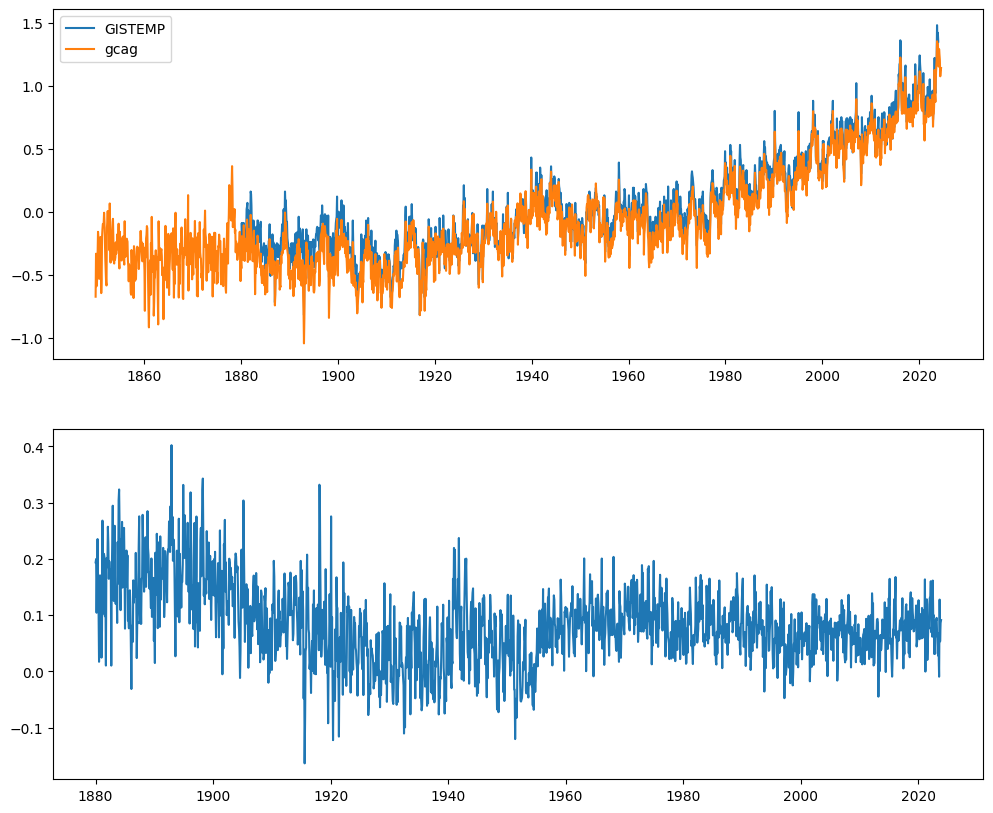

In [102]:
# d) Compare observations from two sources (when both are available).
import matplotlib.pyplot as plt

df_pivoted["temp_diff"] = df_pivoted["GISTEMP_mean"] - df_pivoted["gcag_mean"]
# f) Estimate future temperatures using interpolation methods.
import numpy as np

z1 = np.polyfit(df_pivoted["epoch"], df_pivoted["gcag_mean"], 1)
z2 = np.polyfit(df_pivoted["epoch"], df_pivoted["gcag_mean"], 2)
z3 = np.polyfit(df_pivoted["epoch"], df_pivoted["gcag_mean"], 3)

# e) Visualise global temperature trends (separately from two sources).

plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
plt.plot(df_pivoted["datetime"], df_pivoted["GISTEMP_mean"])
plt.plot(df_pivoted["datetime"], df_pivoted["gcag_mean"])
plt.legend(["GISTEMP", "gcag"])
plt.subplot(2, 1, 2)
plt.plot(df_pivoted["datetime"], df_pivoted["temp_diff"])
plt.show()

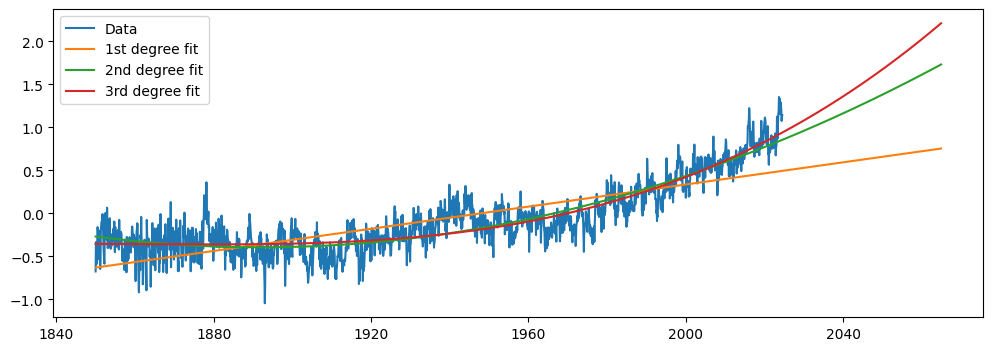

In [103]:
# Define the vector for which we would like to investigate polynomical fit

time_vect = np.arange(df_pivoted["epoch"][0], 3e9, 3600 * 24 * 365)  # time in seconds
time_datetime = pd.to_datetime(time_vect, unit="s")

# visaalisation
plt.figure(figsize=(12, 4))
plt.plot(df_pivoted["datetime"], df_pivoted["gcag_mean"])
plt.plot(time_datetime, time_vect * z1[0] + z1[1])  # first degree
plt.plot(time_datetime, time_vect**2 * z2[0] + time_vect * z2[1] + z2[2])
plt.plot(
    time_datetime,
    time_vect**3 * z3[0] + time_vect**2 * z3[1] + time_vect * z3[2] + z3[3],
)
plt.legend(["Data", "1st degree fit", "2nd degree fit", "3rd degree fit"])

In [106]:
import os

# The zip package contains of seven .csv files. Download the package, extract the files and carry out the following:
# a) Create SQL database company_database.db where each csv file appears as a table. Use SQLite
directory = r"C:\Users\anast\OneDrive - Datu Analytics Oy\Personal\Assignment\Data engineering\Data"

# List all files in the directory
csv_files = [f for f in os.listdir(directory) if f.endswith(".csv")]

# Create an empty dictionary to store DataFrames
dataframes = {}

# Loop through each file and read it into a DataFrame
for file in csv_files:
    # Create a DataFrame for each CSV file, using the filename (without extension) as the key
    df_name = os.path.splitext(file)[
        0
    ]  # Removing the .csv extension for the DataFrame name
    dataframes[df_name] = pd.read_csv(os.path.join(directory, file))

conn_comp = sqlite3.connect("company_database.db")
df_customers = dataframes["customers"]
df_departments = dataframes["departments"]
df_employee_projects = dataframes["employee_projects"]
df_employees_realistic = dataframes["employees_realistic"]
df_order_items = dataframes["order_items"]
df_orders = dataframes["orders"]
df_projects = dataframes["projects"]

df_customers.to_sql("customers", conn_comp, if_exists="replace", index=False)
df_departments.to_sql("departments", conn_comp, if_exists="replace", index=False)
df_employee_projects.to_sql(
    "employee_projects", conn_comp, if_exists="replace", index=False
)
df_employees_realistic.to_sql(
    "employees_realistic", conn_comp, if_exists="replace", index=False
)
df_order_items.to_sql("order_items", conn_comp, if_exists="replace", index=False)
df_orders.to_sql("orders", conn_comp, if_exists="replace", index=False)
df_projects.to_sql("projects", conn_comp, if_exists="replace", index=False)

20

In [ ]:
# b) Query project id, employee id and hours worked from employee_projects and employee id's and salaries from employees_realistic. Join them on employee id.

query1 = """
    SELECT 
        ep.employee_id,
        ep.project_id,
        ep.hours_worked,
        er.salary
    FROM employee_projects AS ep
    JOIN employees_realistic AS er
        ON ep.employee_id = er.employee_id

        """
query_results = pd.read_sql_query(query1, conn_comp)
query_results

,employee_id,project_id,hours_worked,salary
0,25,10,174.7,63059.43
1,92,8,44.5,62315.72
2,90,9,59.4,139659.29
3,50,11,72.2,55178.73
4,64,11,96.4,62059.38
5,52,18,74.1,122598.84
6,32,3,177.1,133670.22
7,19,5,62.9,146812.86
8,84,5,190.7,71305.55
9,89,8,90.1,71724.47


In [ ]:
# c) Calculate the salary costs per project, assuming that the employers salary is annual and number of working hours is 1900 per year.
query2 = """
    SELECT 
        ep.project_id,
        ROUND(SUM(er.salary/1900 * ep.hours_worked),1) AS project_salary_costs 
    FROM employee_projects AS ep
    JOIN employees_realistic AS er
        ON ep.employee_id = er.employee_id
    GROUP by ep.project_id
        """
query_results = pd.read_sql_query(query2, conn_comp)
query_results

,project_id,project_salary_costs
0,1,18602.6
1,2,3058.3
2,3,14113.7
3,5,27521.6
4,6,4734.7
5,7,14514.0
6,8,24007.5
7,9,6839.2
8,10,17400.2
9,11,10994.1


In [ ]:
# d) Join this with the budget in projects table

query3 = """
    SELECT 
        ep.project_id,
        p.budget,
        ROUND(SUM(er.salary/1900 * ep.hours_worked),1) AS project_salary_costs 
    FROM employee_projects AS ep
    JOIN employees_realistic AS er
        ON ep.employee_id = er.employee_id
    JOIN projects AS p
        ON ep.project_id=p.project_id
    GROUP by ep.project_id
        """
query_results = pd.read_sql_query(query3, conn_comp)
query_results

,project_id,budget,project_salary_costs
0,1,25597.90,18602.6
1,2,73139.01,3058.3
2,3,46416.00,14113.7
3,5,87841.22,27521.6
4,6,77580.34,4734.7
5,7,44025.78,14514.0
6,8,44742.77,24007.5
7,9,52671.43,6839.2
8,10,52192.03,17400.2
9,11,43652.42,10994.1


In [ ]:
# e) Calculate how large fraction of the project budget the salary costs are.

query4 = """
    SELECT 
        ep.project_id,
        p.budget,
        ROUND(SUM(er.salary/1900 * ep.hours_worked),1) AS project_salary_costs,
        ROUND(SUM(er.salary/1900 * ep.hours_worked) / p.budget * 100, 1) AS cost_percentage
    FROM employee_projects AS ep
    JOIN employees_realistic AS er
        ON ep.employee_id = er.employee_id
    JOIN projects AS p
        ON ep.project_id=p.project_id
    GROUP by ep.project_id
        """
query_results = pd.read_sql_query(query4, conn_comp)
query_results

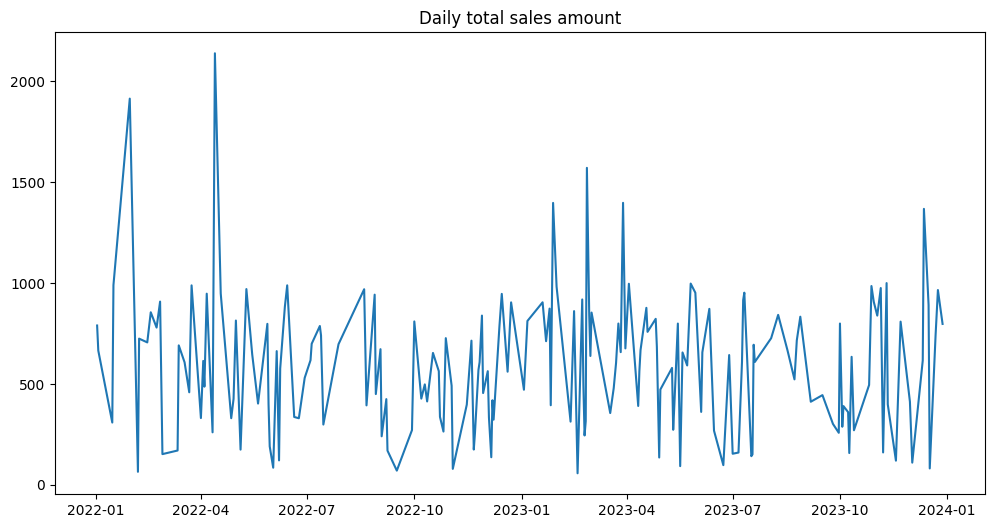

In [ ]:
# 3.Use company database from Exercise 2. Use SQLite and query the daily total amount of sales from table orders. Make a line plot of daily sales using matplotlib.pyplot

query = """
    SELECT 
        order_date as date, 
        SUM(amount) as sales 
        FROM orders 
        GROUP BY order_date

"""
df = pd.read_sql_query(query, conn_comp)
df["date"] = pd.to_datetime(df["date"])  # transfer to date format
plt.figure(figsize=(12, 6))
plt.plot(df["date"], df["sales"])
plt.title("Daily total sales amount")
plt.show()

In [ ]:
# 5: Estimate data storage costs over five years in BigQuery for a company that collects 5 Gb of data every day and keeps all the old data.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

hourly_price = 0.000027397  # per GB
daily_price = hourly_price * 24  # daily accuracy
daily_data = 5
free_tier = 10
start_time = "2025-11-11"
duration = 365 * 5 + 1  # days

# define the list of dates for five years
dates = pd.date_range(pd.Timestamp(start_time), periods=duration).tolist()
dates

# Create a dataframe that contains date, the amount of new data, total amount of data
# daily costs and cumulative costs

df = pd.DataFrame({"time": dates})
df["new_data"] = daily_data  # new data
df["total_data"] = np.cumsum(df["new_data"])  # total data
df["daily_bill"] = (
    df["total_data"] - free_tier
) * daily_price  # daily bill taking into account free tier
df.loc[df["daily_bill"] < 0, "daily_bill"] = 0  # cost if no usage
df["cumulative_bill"] = np.cumsum(df["daily_bill"])

df.head()
print("Total costs for five years are", np.round(df["cumulative_bill"].max()), "$")


Total costs for five years are 5472.0 $


In [ ]:
# 6: Use World Bank population data (bigquery-public-data.world_bank_global_population.population_by_country). Query entire data set to your computer using BigQuery API. Transform the data in Python to the format where the first column is year, other columns are populations in countries. Create table for population in Nordics (headers will be ['year','Finland','Sweden','Norway','Denmark','Iceland’]). Upload this table to BigQuery using API.

# Getting the data from big query
import pandas_gbq

projectid = "smooth-era-483414-n5"
# for authorization, we assume that GOOGLE_APPLICATION_CREDENTIALS points the location of json key

# SQL
sql = """SELECT * FROM `bigquery-public-data.world_bank_global_population.population_by_country`"""
# Read the data
df_raw = pandas_gbq.read_gbq(sql, projectid)
df_raw

Downloading: 100%|██████████|


,country,country_code,year_1960,year_1961,year_1962,year_1963,year_1964,year_1965,year_1966,year_1967,...,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019
0,Sint Maarten (Dutch part),SXM,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,34056,33435,34640,36607,37685,38825,39969,40574,40654,<NA>
1,Not classified,INX,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,West Bank and Gaza,PSE,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,3786161,3882986,3979998,4076708,4173398,4270092,4367088,4454805,4569087,<NA>
3,Serbia,SRB,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,7291436,7234099,7199077,7164132,7130576,7095383,7058322,7020858,6982084,<NA>
4,Cambodia,KHM,5722370,5872966,6028431,6183584,6331449,6467197,6585035,6685960,...,14312212,14541423,14780454,15026332,15274503,15521436,15766293,16009414,16249798,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Northern Mariana Islands,MNP,9979,10245,10436,10590,10783,11022,11344,11721,...,53971,54012,54311,54784,55305,55780,56188,56562,56882,<NA>
260,St. Kitts and Nevis,KNA,51195,51192,50963,50525,49931,49214,48358,47381,...,49016,49447,49887,50331,50774,51203,51625,52045,52441,<NA>
261,Bolivia,BOL,3656955,3728964,3802990,3879192,3957757,4038872,4122517,4208676,...,10048590,10212954,10377676,10542376,10706517,10869730,11031813,11192854,11353142,<NA>
262,French Polynesia,PYF,78076,80706,83655,86847,90139,93438,96716,99995,...,266455,267698,268998,270328,271705,273124,274575,276103,277679,<NA>


In [ ]:
# Data Transform
df_tr = df_raw.T  # Transpose
df_tr.columns = df_tr.iloc[0]
df_tr = df_tr.drop(df_tr.index[[0, 1]])
df_tr.reset_index(inplace=True)
df_tr.columns.name = None
df_tr = df_tr.rename(columns={"index": "year"})
df_tr = df_tr.applymap(
    lambda x: str(x).replace("year_", "") if isinstance(x, str) else x
)  # drop year_ in front
df_tr["year"] = pd.to_numeric(df_tr["year"])
df_tr = df_tr[
    ["year", "Finland", "Sweden", "Norway", "Denmark", "Iceland"]
]  # select certain columns
df_tr = df_tr.drop(df_tr.tail(1).index)  # drop missing rows
df_tr = df_tr.astype(int)
df_tr


C:\Users\anast\AppData\Local\Temp\ipykernel_1440\156506496.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_tr = df_tr.applymap(lambda x: str(x).replace('year_', '') if isinstance(x, str) else x) # drop year_ in front


,year,Finland,Sweden,Norway,Denmark,Iceland
0,1960,4429634,7484656,3581239,4579603,175574
1,1961,4461005,7519998,3609800,4611687,179029
2,1962,4491443,7561588,3638918,4647727,182378
3,1963,4523309,7604328,3666537,4684483,185653
4,1964,4548543,7661354,3694339,4722072,188983
5,1965,4563732,7733853,3723168,4759012,192286
6,1966,4580869,7807797,3753012,4797381,195570
7,1967,4605744,7867931,3784539,4835354,198751
8,1968,4626469,7912273,3816486,4864883,201488
9,1969,4623785,7968072,3847707,4891860,203369


In [ ]:
# Upload to BQ

dataset = "test_data_2025_US"
table_name = "Nordics_population"
destination = dataset + "." + table_name

df_tr.to_gbq(destination, project_id=projectid, if_exists="replace")  # upload

C:\Users\anast\AppData\Local\Temp\ipykernel_1440\1055533653.py:7: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df_tr.to_gbq(destination, project_id=projectid, if_exists='replace') #upload
100%|██████████| 1/1 [00:00<00:00, 1810.23it/s]


In [149]:
#7: Use BigQuery public data for names in USA (`bigquery-public-data.usa_names.usa_1910_current`). Write a query to find the most common male and female name for every year. Save results to table US_common_names. Use BigQuery API and action query in a way that the data is not moved from BigQuery.

#Write SQL in Big Query 

WITH summed_numbers AS (
  SELECT 
    gender, 
    year, 
    name, 
    SUM(number) AS number  -- Summing up the number of occurrences by gender, year, and name
  FROM `bigquery-public-data.usa_names.usa_1910_current`
  GROUP BY gender, year, name
),
max_numbers AS (
  SELECT 
    gender,
    year, 
    MAX(number) AS max_number  -- Find the maximum summed number per gender and year
  FROM summed_numbers
  GROUP BY gender, year
)
SELECT 
  sn.gender,
  sn.year, 
  sn.name, 
  sn.number
FROM summed_numbers sn
JOIN max_numbers mn
  ON sn.gender = mn.gender 
  AND sn.year = mn.year
  AND sn.number = mn.max_number  -- Only select rows with the max number
ORDER BY sn.year, sn.gender;  -- Sorting by year and gender

from google.cloud import bigquery
client = bigquery.Client()

#data destination
projectid = "smooth-era-483414-n5"
dataset ='test_data_2025_US'
table_name = 'US_name_table'
destination = projectid + '.' + dataset + dataset + '.' + table_name #full destination path

job_config = bigquery.QueryJobConfig (desitnation = destination)
job_config.write_disposition = 'WRITE_TRUNCATE' #REplace if exists 

query_job = client.query (sql,job_config=job_config) #API request 
query_job.restults()
print("Query results loaded to the table {}".format(destination))



SyntaxError: invalid syntax (4054858727.py, line 5)

In [ ]:
# 8. Write a Jupyter notebook to complete the following tasks.
# a) Query raw data from Google Analytics 4 example table bigquery-public-data.ga4_obfuscated_sample_ecommerce  from the time range  from 2021-01-15 to  2021-01-31 (WHERE _TABLE_SUFFIX between '20210115' and  '20210131') Query user_pseudo_id, number of events and total revenue per user. 
# b) Save query results to the destination BigQuery table. Note that data should stay in BigQuery during the processing, don’t download a local copy! The destination should be under your own project and data set, like my_project_name.G4_daily_user.G4_daily_user_data. You need to create the data set in the BigQuery console
# c) Query data from the table you created. Import data to the local pandas dataframe.
# d) Visualize basic quantities, like a bar chart of revenue for the top 20 customers. 
SELECT 
user_pseudo_id,
count(*) as number_of_events,
max(user_ltv.revenue) as revenue
FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
WHERE _TABLE_SUFFIX between '20210115' and  '20210131' 
group by user_pseudo_id
order by revenue DESC

SyntaxError: unmatched ')' (1031231242.py, line 4)

In [ ]:
# 9: Create a Docker image and container using this data visualization and related data file from earlier course.

